# Reverse Docking

This notebook demonstrates how a variety of different tools can be glued together into an efficient and flexible workflow using **Crossflow**.

The workflow docks a ligand (PRZ) to a set of protein structures (taken from the cryptosite database).

The notebook requires **fpocket** and **autodock vina** to be installed on the worker node(s) of your dask cluster.

In [1]:
from crossflow import filehandling, tasks, clients
from distributed import LocalCluster
import numpy as np
import mdtraj as mdt
from pathlib import Path

Create a crossflow client, connected to a local pool of workers:

In [2]:
cluster = LocalCluster(n_workers=1, threads_per_worker=1)
client = clients.Client(cluster)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 1
Total threads: 1,Total memory: 16.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:62349,Workers: 1
Dashboard: http://127.0.0.1:8787/status,Total threads: 1
Started: Just now,Total memory: 16.00 GiB
Comm: tcp://127.0.0.1:62354,Total threads: 1
Dashboard: http://127.0.0.1:62355/status,Memory: 16.00 GiB
Nanny: tcp://127.0.0.1:62352,


Make the SubprocessTasks for **fpocket** and **Vina**, and FunctionTasks for other tasks:

In [39]:
# The provisioning task - run on all workers before they do anything else
provision = tasks.SubprocessTask('chmod +x provision.sh && ./provision.sh')
provision.set_inputs(['provision.sh'])
provision.set_outputs(['STDOUT'])

In [3]:
# The fpocket task:
fpocket = tasks.SubprocessTask('rex fpocket -f x.pdb')
fpocket.set_inputs(['x.pdb'])
fpocket.set_outputs(['x_out/x_out.pdb'])

In [4]:
# The vina task:
vina = tasks.SubprocessTask('rex vina --receptor r.pdbqt --ligand l.pdbqt --out out.pdbqt > dock.log'
                                 ' --config conf.dat --num_modes 1')
vina.set_inputs(['r.pdbqt', 'l.pdbqt', 'conf.dat'])
vina.set_outputs(['out.pdbqt', 'dock.log'])

In [7]:
def _pdbqt2pdb(infile):
    '''
    A Function to convert pdbqt files back to pdb ones
    
    Args:
        infile (str): name of the input file, .pdbqt format
    
    Returns:
        str: name of the .pdb file (always 'tmp.pdb')
    '''
    outfile = 'tmp.pdb'
    fout = open(outfile, 'w')
    with open(infile, 'r') as fin:
        for line in fin:
            if line[1:6] in 'ATOM  MODEL ENDMDL':
                fout.write(line)       
    fout.close()
    return 'tmp.pdb'

# Now make a FunctionTask for this:
pdbqt2pdb = tasks.FunctionTask(_pdbqt2pdb)
pdbqt2pdb.set_inputs(['infile'])
pdbqt2pdb.set_outputs(['outfile'])

In [12]:
def _get_dimensions(pockets):
    '''
    A Function to find the centre and extents of each of the pockets found by fpocket
    
    Args:
        pockets (str): Name of the pdb format file produced by fpocket
        
    Returns:
        configs: the pocket centres and extents in x/y/z - in Angstroms, in vina .conf format
    '''
    buffer = 2.0 # buffer added to pocket extents (Angstroms)
    t = mdt.load(pockets)
    n_pockets = len([r for r in t.topology.residues if r.name == 'STP'])
    confs = []
    template = 'center_x = {:6.3f}\ncenter_y = {:6.3f}\ncenter_z = {:6.3f}\nsize_x = {:6.3f}\nsize_y = {:6.3f}\nsize_z = {:6.3f}\n'
    for ip in range(n_pockets):
        site = t.topology.select('resname STP and residue {}'.format(ip + 1))
        # In the next two lines, the factor of 10 is a conversion from nanometres to Angstroms:
        xc, yc, zc = tuple(10 * (t.xyz[0][site].min(axis=0) + t.xyz[0][site].max(axis=0)) / 2)
        sx, sy, sz = tuple(10 * (t.xyz[0][site].max(axis=0) - t.xyz[0][site].min(axis=0)) + buffer)
        conftext = template.format(xc, yc, zc, sx, sy, sz)
        conf_handle = fh.create(f'conf_{ip}.dat')
        conf_handle.write_text(conftext)
        confs.append(conf_handle)
        
    return confs

# Now make a FunctionTask for this:
get_dimensions = tasks.FunctionTask(_get_dimensions)
get_dimensions.set_inputs(['pockets'])
get_dimensions.set_outputs(['confs'])

In [14]:
help(get_dimensions)

Help on FunctionTask in module crossflow.tasks object:

class FunctionTask(builtins.object)
 |  FunctionTask(func)
 |  
 |  Methods defined here:
 |  
 |  __cal__(self, *args)
 |  
 |  __init__(self, func)
 |      Arguments:
 |          func: the Python function to wrap
 |  
 |  copy(self)
 |      Return a copy of the task
 |  
 |  run(self, *args)
 |      Run the task/function with the given arguments.
 |      
 |      Returns:
 |          Whatever the function returns, with output files converted
 |              to FileHandle objects
 |  
 |  set_constant(self, key, value)
 |      Set a parameters for the task
 |  
 |  set_inputs(self, inputs)
 |      Set the inputs the task requires
 |  
 |  set_outputs(self, outputs)
 |      Set the outputs the task produces
 |  
 |  ----------------------------------------------------------------------
 |  Data descriptors defined here:
 |  
 |  __dict__
 |      dictionary for instance variables (if defined)
 |  
 |  __weakref__
 |      list of we

In [6]:
fh = filehandling.FileHandler()
#provisionscript = fh.load('provision.dat')
#results = client.map(provision, [provisionscript] * 8) # >= max number of workers
#print(results[0].result())

Now we construct the workflow. For convenience it's split up here into sections.

In [7]:
receptor_dir = Path('./receptors')
receptor_files = receptor_dir.glob('*.pdbqt')
pdbcodes = []
receptors = []
for r in receptor_files:
    receptors.append(fh.load(r))
    pdbcodes.append(r.stem[:4])

In [8]:
print(pdbcodes)

['3hl8', '1za1', '2brl', '1ftl', '1ecc', '3ip0', '2piq', '2wkw', '1afq', '3hl7', '2ofp', '1u1d', '2h4k', '1pzy', '1eyj', '3hqp', '2yqs', '2bys', '3f82', '3lth', '3hok', '3bl7', '1gzf', '2w5k', '1q0b', '1t49', '1g67', '1oke', '2iyq', '3fgo', '1gky', '2oo8', '2ixu', '1yv3', '2q8h', '1lic', '1tr5', '3cfn', '2ohv', '3gqz', '1cib', '1j6z', '2gir', '1xvc', '2hka', '2ieg', '1ow3', '1ryo', '1s9d', '3fqk', '1d6y', '2iuz', '2gz7', '3bqm', '1imb', '1l5s', '2bu2', '1br6', '1ey3', '2egh', '2hvd', '3eks', '3dhh', '1ghy', '1nx3', '1ha3', '2jds', '3dc1', '2wi7', '1ank', '2v57', '2eum', '3h9j', '1fqc', '2npq', '3ixj', '3hzt', '2al4', '1ctr']


In [9]:
def best_affinity(logfiles):
    '''
    Return the affinity of the top-ranked pose
    '''
    best_a = 0.0
    best_p = None
    for i, logfile in enumerate(logfiles):
        for line in logfile.result().read_text().split('\n'):
            if '   1   ' in line:
                if float(line.split()[1]) < best_a:
                    best_a = float(line.split()[1])
                    best_p = i                            
    return best_p, best_a

# prepare ligand for docking
#ligand_qt = client.submit(prep_ligand, ligand)

In [10]:
pockets = client.map(fpocket, receptors[:5])

In [13]:
confs = client.map(get_dimensions, pockets)

TypeError: First input to map must be a callable function

In [50]:
print(confs.result()[0].read_text())

center_x = 17.646
center_y = 29.888
center_z = 14.020
size_x = 13.779
size_y = 18.657
size_z = 12.396



In [76]:
ligand = fh.load('prz.pdbqt')
docks, logs = client.map(vina, receptors[0], ligand, list(confs.result()))

In [78]:
print(type(confs.result()))

<class 'tuple'>


In [77]:
print(best_affinity(logs))

(7, -5.394)


In [14]:
# prepare ligand for docking
ligand_qt = client.submit(prep_ligand, ligand)
ligand_qt.result().save('prz.pdbqt')
for pdbcode, chain_id in zip(pdbcodes, chain_ids):
    receptor = download_and_select(pdbcode, chain_id)
    receptor.save(f'{pdbcode}_receptor.pdb')
    # Prepare receptor for docking:
    receptor_qt = client.submit(prep_receptor, receptor)
    receptor_qt.result().save(f'{pdbcode}_receptor.pdbqt')
    
    

2023-09-17 09:46:38,127 - distributed.utils_perf - WARNING - full garbage collections took 24% CPU time recently (threshold: 10%)
2023-09-17 09:46:38,334 - distributed.utils_perf - WARNING - full garbage collections took 25% CPU time recently (threshold: 10%)
2023-09-17 09:46:41,601 - distributed.utils_perf - WARNING - full garbage collections took 24% CPU time recently (threshold: 10%)
2023-09-17 09:46:43,685 - distributed.utils_perf - WARNING - full garbage collections took 24% CPU time recently (threshold: 10%)
2023-09-17 09:46:46,214 - distributed.utils_perf - WARNING - full garbage collections took 24% CPU time recently (threshold: 10%)
2023-09-17 09:46:46,409 - distributed.utils_perf - WARNING - full garbage collections took 24% CPU time recently (threshold: 10%)
2023-09-17 09:46:49,599 - distributed.utils_perf - WARNING - full garbage collections took 24% CPU time recently (threshold: 10%)
2023-09-17 09:46:53,205 - distributed.utils_perf - WARNING - full garbage collections took

2023-09-17 09:48:39,403 - distributed.utils_perf - WARNING - full garbage collections took 26% CPU time recently (threshold: 10%)
2023-09-17 09:48:39,761 - distributed.utils_perf - WARNING - full garbage collections took 27% CPU time recently (threshold: 10%)
2023-09-17 09:48:40,273 - distributed.utils_perf - WARNING - full garbage collections took 27% CPU time recently (threshold: 10%)
2023-09-17 09:48:43,678 - distributed.utils_perf - WARNING - full garbage collections took 26% CPU time recently (threshold: 10%)
2023-09-17 09:48:43,955 - distributed.utils_perf - WARNING - full garbage collections took 26% CPU time recently (threshold: 10%)
2023-09-17 09:48:46,010 - distributed.utils_perf - WARNING - full garbage collections took 27% CPU time recently (threshold: 10%)
2023-09-17 09:48:48,297 - distributed.utils_perf - WARNING - full garbage collections took 26% CPU time recently (threshold: 10%)
2023-09-17 09:48:48,488 - distributed.utils_perf - WARNING - full garbage collections took

In [55]:
for pdbcode, chain_id in zip(pdbcodes, chain_ids):
    # Download structure:
    receptor = download_and_select(pdbcode, chain_id)
    
    # Run fpocket:
    pockets = client.submit(fpocket, receptor)

    # Find the dimensions of each pocket
    xcs, ycs, zcs, sxs, sys, szs = client.submit(get_dimensions, pockets)

    # Prepare receptor for docking:
    receptor_qt = client.submit(prep_receptor, receptor)


    # Run vina:
    docks, logfiles = client.map(vina, receptor_qt, ligand_qt, xcs.result(), ycs.result(), zcs.result(), sxs.result(), sys.result(), szs.result())

    # Look through the log files for each pocket to find the best:

    best_p, best_a = best_affinity(logfiles)
    print(pdbcode, best_p, best_a)
    

1qy1 0 -5.8


In [15]:
cryptodata = '''2iuz -5.2
1yv3 -6.5
2jds -5.4
1lic -4.8
2hka -5.5
3eks -5.4
1nx3 -4.8
2yqs -4.9
2wi7 -5.4
1br6 -5.3
1j6z -5.8
1tr5 -5.3
1fqc -5.3
2hvd -4.5
3f82 -5.2
1g67 -5.1
3bqm -5.4
1ftl -4.8
1d6y -5.1
1ey3 -5.0
1pzy -5.4
1xvc -5.9
1imb -4.9
2piq -5.3
1ha3 -5.0
3lth -5.0
3dhh -4.1
1ctr -4.4
3h9j -4.8
3hok -5.1
2wkw -4.5
1ghy -5.0
1oke -4.9
3hzt -5.3
2egh -5.6
3ip0 -6.4
2bu2 -5.8
2ohv -5.1
3gqz -5.2
2w5k -4.0
1cib -5.4
2ofp -4.7
2ixu -4.4
3bl7 -4.4
1ryo -5.8
2q8h -5.0
2iyq -5.7
1gky -5.5
1s9d -4.9
1ecc -5.8
2h4k -5.2
1eyj -4.7
2brl -4.8
3fqk -5.3
2gz7 -4.5
2v57 -5.2
1cib -5.3
1l5s -5.6
3ixj -5.3
2al4 -4.3
3hqp -5.8
1u1d -4.9
2oo8 -5.1
1q0b -5.6
2npq -5.3
2bys -6.2
2gir -5.1
3cfn -4.2
1afq -5.0
1ow3 -5.0
3hl8 -5.4
1ank -5.8
3hl7 -6.0
2ieg -5.4
2eum -5.7
3dc1 -4.4
1t49 -5.2
1gzf -5.3
3fgo -5.5
1za1 -4.9
1qy1 -5.8'''

In [17]:
cd = cryptodata.split('\n')
cd.sort(key=lambda x: x.split()[1])
print(cd)

['2w5k -4.0', '3dhh -4.1', '3cfn -4.2', '2al4 -4.3', '1ctr -4.4', '2ixu -4.4', '3bl7 -4.4', '3dc1 -4.4', '2hvd -4.5', '2wkw -4.5', '2gz7 -4.5', '2ofp -4.7', '1eyj -4.7', '1lic -4.8', '1nx3 -4.8', '1ftl -4.8', '3h9j -4.8', '2brl -4.8', '2yqs -4.9', '1imb -4.9', '1oke -4.9', '1s9d -4.9', '1u1d -4.9', '1za1 -4.9', '1ey3 -5.0', '1ha3 -5.0', '3lth -5.0', '1ghy -5.0', '2q8h -5.0', '1afq -5.0', '1ow3 -5.0', '1g67 -5.1', '1d6y -5.1', '3hok -5.1', '2ohv -5.1', '2oo8 -5.1', '2gir -5.1', '2iuz -5.2', '3f82 -5.2', '3gqz -5.2', '2h4k -5.2', '2v57 -5.2', '1t49 -5.2', '1br6 -5.3', '1tr5 -5.3', '1fqc -5.3', '2piq -5.3', '3hzt -5.3', '3fqk -5.3', '1cib -5.3', '3ixj -5.3', '2npq -5.3', '1gzf -5.3', '2jds -5.4', '3eks -5.4', '2wi7 -5.4', '3bqm -5.4', '1pzy -5.4', '1cib -5.4', '3hl8 -5.4', '2ieg -5.4', '2hka -5.5', '1gky -5.5', '3fgo -5.5', '2egh -5.6', '1l5s -5.6', '1q0b -5.6', '2iyq -5.7', '2eum -5.7', '1j6z -5.8', '2bu2 -5.8', '1ryo -5.8', '1ecc -5.8', '3hqp -5.8', '1ank -5.8', '1qy1 -5.8', '1xvc -5.9'

In [18]:
from matplotlib import pyplot as plt
%matplotlib inline

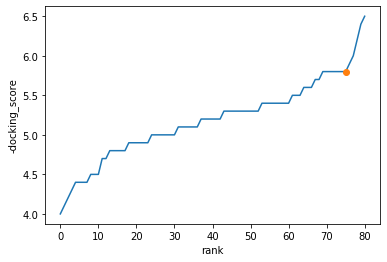

In [65]:
#plt.figure(figsize=(10,7))
scores = np.array([-float(c.split()[1]) for c in cd])
ids = [c.split()[0] for c in cd]
plt.plot(scores)
q = ids.index('1qy1')
plt.plot(q, scores[q], 'o')
plt.xlabel('rank')
plt.ylabel('-docking_score')
plt.savefig('inverse_results.png')

In [60]:
top5 = ids[-5:]
print(top5)
print(len(scores))

['1xvc', '3hl7', '2bys', '3ip0', '1yv3']
81


In [58]:
with open('complexes.list') as f:
    receptors = f.readlines()
pdbcodes = [r[:4].lower() for r in receptors if r[:4].lower() in top5]
chain_ids = [r[4] for r in receptors if r[:4].lower() in top5]
print(pdbcodes)
print(chain_ids)

['1yv3', '1xvc', '3ip0', '2bys', '3hl7']
['A', 'A', 'A', 'J', 'A']


In [59]:
for pdbcode, chain_id in zip(pdbcodes, chain_ids):
    # Download structure:
    receptor = download_and_select(pdbcode, chain_id)
    
    # Run fpocket:
    pockets = client.submit(fpocket, receptor)

    # Find the dimensions of each pocket
    xcs, ycs, zcs, sxs, sys, szs = client.submit(get_dimensions, pockets)

    # Prepare receptor for docking:
    receptor_qt = client.submit(prep_receptor, receptor)


    # Run vina:
    docks, logfiles = client.map(vina, receptor_qt, ligand_qt, xcs.result(), ycs.result(), zcs.result(), sxs.result(), sys.result(), szs.result())

    # Look through the log files for each pocket to find the best:

    best_p, best_a = best_affinity(logfiles)
    print(pdbcode, best_p, best_a)
    docks[best_p].result().save('{}_{}.pdbqt'.format(pdbcode, best_p))

1yv3 0 -6.4
1xvc 0 -5.9
3ip0 0 -6.4
2bys 0 -6.2
3hl7 0 -5.3
